# GRU Neural Network Implemented with `edf`

This Recurrent network learns from [Shakespear's Coriolanus](./input.txt). 

This Gated Recurrent Unit (GRU) is similar to the [LSTM notebook](../003_LSTM_with_edf/LSTM_Long_Short_Term_Memory_with_edf.ipynb). In this setup, The GRU cell is used as following

```python

gru = GRU(params)

for t in range(len(input_string)):

    h[t+1], y[t] = gru.chain(h[t], x[t])

    loss = loss + Dot@{Softmax(y[t]), targets[t]}

```


In [1]:
import numpy as np
import edf
from time import time
import pickle
import os
from pprint import pprint
from tqdm import tqdm
from termcolor import cprint

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
HIDDEN_SIZE = 65  # size of hidden layer of neurons
SEQ_LENGTH = 25  # number of steps to unroll the RNN for
ETA = 1e-3

In [3]:
# data I/O
#data = open('input.txt', 'r').read()  # should be simple plain text file

data = "This is a little fox. 中文输入法也没有问题！" * 100
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has {} characters, {} unique.'.format(data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 3300 characters, 24 unique.


In [4]:
char_inds = np.array(list(map(lambda char: char_to_ix[char], data)))
tail = len(data) % SEQ_LENGTH
pad_length = SEQ_LENGTH - tail if tail else 0;

batched_data = np.append(char_inds, np.zeros(pad_length), axis=0)
batched_data.resize((int(len(data)/SEQ_LENGTH), SEQ_LENGTH))
# assert batched_data.shape == (44615, 25)

In [5]:
def one_hot(N, x):
    
    shape = x.shape
    x.resize(x.size)
    encoded = np.zeros([x.size, N])
    
    for i in range(x.size):
        encoded[i, int(x[i])] = 1
    
    encoded.resize(list(shape) + [N])
    x.resize(shape)
    # print(shape)
    return encoded

# tests:
encoded = one_hot(65, batched_data)
# assert encoded.shape == (44615, 25, 65), "shape is incorrect"
one_hot(5, np.array([3]))

array([[ 0.,  0.,  0.,  1.,  0.]])

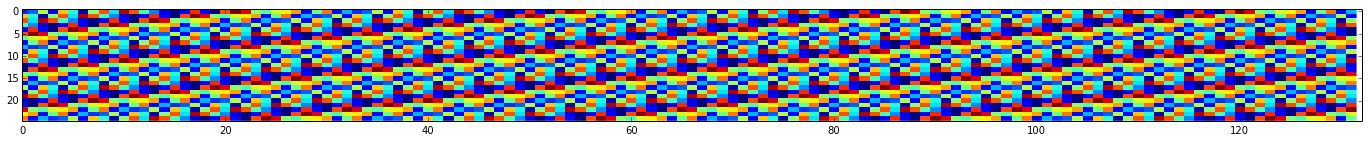

In [6]:
encoded = one_hot(vocab_size, batched_data)
plt.figure(figsize=(24,2))
plt.imshow(np.argmax(encoded, axis=2).T, aspect='auto', interpolation="none")
plt.xlim(0, encoded.shape[0])
plt.show()

minimum forward and backward computation example with the operators.

## The mathematical description of GRU

Compared with the graphical representation, the equations leave no anbiguity and is easier to use as a reference.

Note: $h_t$ has the same dimension as the input vector $x_t$.
\begin{aligned} 
z &= \sigma(x_t U_z + s_{t-1} W_z + b_z) \\ 
r &= \sigma(x_t U_r + s_{t-1} W_r + b_r) \\ 
h &= \tanh(x_t U_h + (s_{t-1} \circ r) W_h + b_h) \\ 
s_t &= (1 - z) \circ h + z \circ s_{t-1} 
\end{aligned}

In [7]:
class GRU:
    
    def __init__(self, Uz, Wz, bz, Ur, Wr, br, Uh, Wh, bh):
        self.Uz = Uz
        self.Wz = Wz
        self.bz = bz
        self.Ur = Ur
        self.Wr = Wr
        self.br = br
        self.Uh = Uh
        self.Wh = Wh
        self.bh = bh
        self.unity = edf.Value(1.0)
        self.minus_one = edf.Value(-1.0)
        
    def chain(self, x_t, s_t_minus):
        #input: x_t, s_t_minus 
        # return: s_t, h_t
        z_t = edf.Sigmoid(
            edf.Add(
                edf.Add(
                    edf.VDot(x_t, self.Uz),
                    edf.VDot(s_t_minus, self.Wz)
                ), self.bz))
        r_t = edf.Sigmoid(
            edf.Add(
                edf.Add(
                    edf.VDot(x_t, self.Ur),
                    edf.VDot(s_t_minus, self.Wr)
                ), self.br))
        # output vector
        h_t = edf.Tanh(
            edf.Add(
                edf.Add(
                    edf.VDot(x_t, self.Uh),
                    edf.VDot(s_t_minus, self.Wh)
                ), self.bh))
        s_t = edf.Add(
            edf.Mul(
                edf.Add(self.unity, edf.Mul(z_t, self.minus_one)),
                h_t
            ), 
            edf.Mul(z_t, s_t_minus)
        )
        
        return s_t, h_t

In [8]:
# single input, no batching.
def build_network(params, inputs, s0):
    
    Uz, Wz, bz, Ur, Wr, br, Uh, Wh, bh, C2V, V2C = params
    
    input_len = inputs.shape[0]
    
    # clear edf.component graph
    edf.components = []
    
    # C and h are just plain python arrays
    s = [s0] + [None] * input_len
    h = [None] * input_len
    preds = [None] * input_len
    
    loss = edf.Value(0)
    
    # instantiate network
    gru = GRU(Uz, Wz, bz, Ur, Wr, br, Uh, Wh, bh)
    
    # unfold the forward passage
    for t in range(input_len):
        
        current_char = edf.Value(inputs[t])
        
        char_vec = edf.VDot(current_char, C2V)
        
        s[t + 1], h[t] = gru.chain(char_vec, s[t])
        
        # find prediction before calculating score.
        # a better way is to compute score with the confidence level
        # in mind.
        
        pred = edf.SoftMax(edf.VDot(h[t], V2C))
        
        preds[t] = pred
        
        log = edf.Log(edf.Sum(edf.Mul(pred, current_char))) # always over axis=-1
        
        loss = edf.Add(loss, edf.Mul(log, edf.Value(-1)))
        
    return preds, loss, s

In [9]:
# clear edf params graph
edf.params = []

# LSTM definition

Uf = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
Wf = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
bf = edf.Param(np.zeros((HIDDEN_SIZE)))

Ur = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
Wr = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
br = edf.Param(np.zeros((HIDDEN_SIZE)))

Uh = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
Wh = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
bh = edf.Param(np.zeros((HIDDEN_SIZE)))

# You also need a FC layer to project the character space into 
# the hiddel parameter space
C2V = edf.Param(np.random.random((vocab_size, HIDDEN_SIZE)))
V2C = edf.Param(np.random.random((HIDDEN_SIZE, vocab_size)))

# initialize with a zero vector.
s0 = edf.Value(np.zeros([HIDDEN_SIZE]))

losses = []

for batch in batched_data:
    # print(batch)
    inputs = one_hot(vocab_size, batch)
    
    preds, loss, s = build_network(edf.params, inputs, s0)
    
    edf.Forward()
    
    s0 = edf.Value(s[-1].value)
    
    edf.Backward(loss)
    
    output = "".join(list(map(lambda pred: ix_to_char[np.argmax(pred.value)], preds)
        ))    
    print(output, end='')
    losses.append(loss.value)
    edf.Adam(ETA)

iiii入ii入没入tt中中tt入itii入i.没iittiiiiiiiiiiiiiltt中中ttiioiiiiliiittiiiiiiii iiiiliooooiiioiiiiiTiit有ii ii io io s oosooo ioii i Tiit有t  文  i输 io s   s      i  i T ih有T      s  s s T s      h  i T ih有T     is is a T s      h  i T 法h有h 题   is is a   s      h  i   法h有h 题   is is a iis l  foh. i  入法h有t 题   is is a littlt foh. i 输入法h有t问题 i is is a littlt foi. i 输入法t有t问题 i is is a littlt fot. i 输入法也没t问题！i is is a littlt fox. i 输入法也没t问题！ihis is a littlt fox. i 输入法也没t问题！This is a little fox. i文输入法也没t问题！This is a little fox. i文输入法也没中问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a little fox. 中文输入法也没有问题！This is a 

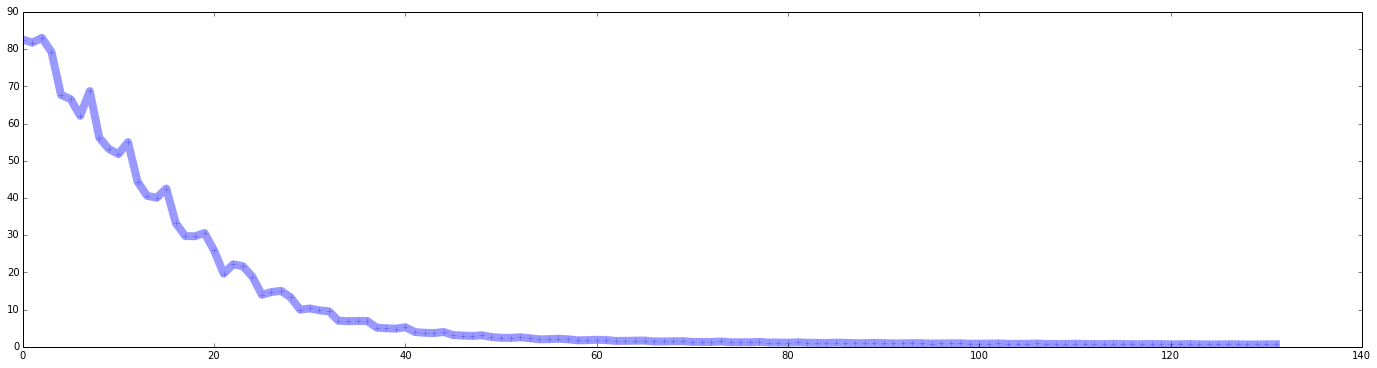

In [12]:
plt.figure(figsize=(24, 6))
plt.plot(losses, '+-', alpha=0.4, linewidth=8)

In [13]:
# hyperparameters
HIDDEN_SIZE = 65  # size of hidden layer of neurons
SEQ_LENGTH = 25  # number of steps to unroll the RNN for
ETA = 1e-3

In [14]:
# load full shakespear data
data = open('input.txt', 'r').read()  # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has {} characters, {} unique.'.format(data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [15]:
char_inds = np.array(list(map(lambda char: char_to_ix[char], data)))
tail = len(data) % SEQ_LENGTH
pad_length = SEQ_LENGTH - tail if tail else 0;

batched_data = np.append(char_inds, np.zeros(pad_length), axis=0)
batched_data.resize((int(len(data)/SEQ_LENGTH), SEQ_LENGTH))

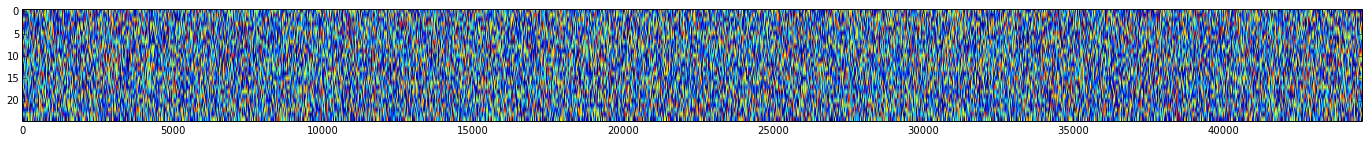

In [16]:
encoded = one_hot(vocab_size, batched_data)
plt.figure(figsize=(24,2))
plt.imshow(np.argmax(encoded, axis=2).T, aspect='auto')
plt.xlim(0, encoded.shape[0])
plt.show()

In [18]:
# clear edf params graph
edf.params = []

# GRU Parameter definition

Uf = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
Wf = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
bf = edf.Param(np.zeros((HIDDEN_SIZE)))

Ur = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
Wr = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
br = edf.Param(np.zeros((HIDDEN_SIZE)))

Uh = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
Wh = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))
bh = edf.Param(np.zeros((HIDDEN_SIZE)))

# You also need a FC layer to project the character space into 
# the hiddel parameter space
C2V = edf.Param(np.random.random((vocab_size, HIDDEN_SIZE)))
V2C = edf.Param(np.random.random((HIDDEN_SIZE, vocab_size)))

# initialize with a zero vector.
s0 = edf.Value(np.zeros([HIDDEN_SIZE]))

losses = []

for batch in batched_data:
    # print(batch)
    inputs = one_hot(vocab_size, batch)
    
    preds, loss, s = build_network(edf.params, inputs, s0)
    
    edf.Forward()
    
    s0 = edf.Value(s[-1].value)
    
    edf.Backward(loss)
    
    output = "".join(list(map(lambda pred: ix_to_char[np.argmax(pred.value)], preds)
        ))    
    print(output, end='')
    losses.append(loss.value)
    edf.Adam(ETA)

bboeoeffefexeexexFIoeelxeeoeeeeeeeeeeFooeeeeeeeeeeeeeeeIeeeefoeooPoo:eeeeee eeeeoooeoeee eeeeeeeo IoFFoeF:   oeeI  o SoFeeeoF:F   e  eF h F   : e          :           
       
   
          
       
    
l     l    l  l            eP   
   e   
     
J  
  e   el         el e  

  e
   e  e e  ee ee e    eae   e  ie    ea e  eee ie eee el   eelet

ete    ee   e       
e
 eeee e leeee e eet  et  e  e  o et iliet ilieei
telt     t  ent
t e ltt t i
     t  entt

t ttt   t  ent
 e  oe  ltoonte  tooo   t  entt tee t to t  nt  oo  
 e t  oteoo te eooie te on ioo   oe  e e oet ii teee

oo   eie   oe  ot eee eoteni o te  iei e it iete

en eeoye  ie yieet aeeet teee oel e e  oe eeeanelea
 ee eeee teine le ate too  eatt tee teanness teat
 ttl tts ost tee o oett ot oot tisetet is as antintentote to tattitrl t se tee t atentantes oot
suttetante is a tain to teet  et os te enue this lith
oue ti est ere  e aeaoye rahes: ior the ao s  nol h
stea  this in hunuer ior ireah  not in thirst ior re enue 



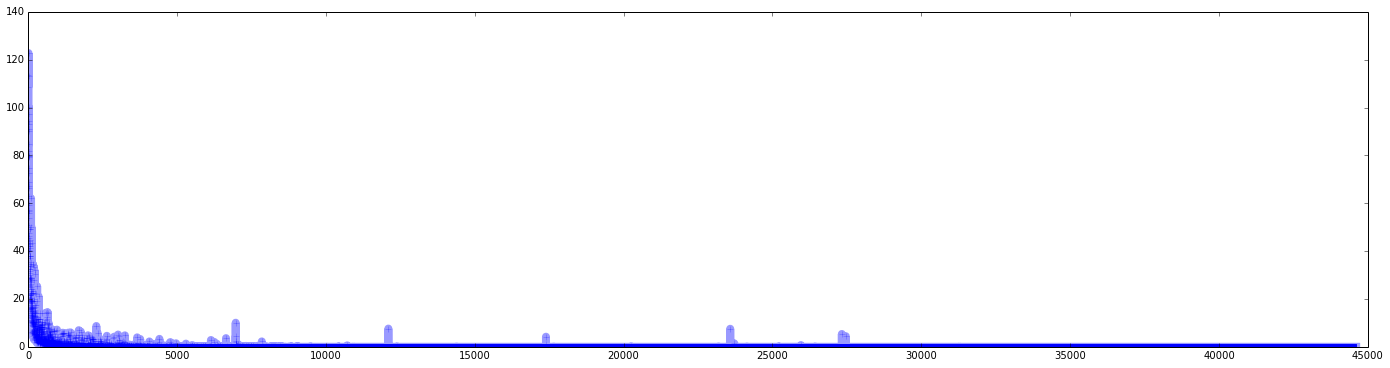

In [19]:
plt.figure(figsize=(24, 6))
plt.plot(losses, '+-', alpha=0.4, linewidth=8)